# 数字识别实验
## 实验基本情况
* 基于Mnist数据集
* 采用LeNet卷积神经网络训练

In [101]:
import torch
from torch.utils import data
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

def get_data_mnist(batch_size,loaders=0,resize=None):
    trans=[transforms.ToTensor()]
    if resize:
        trans.insert(0,transforms.Resize(resize))
    trans=transforms.Compose(trans)
    mnist_train=torchvision.datasets.MNIST(
        root='../data',train=True,download=True,transform=trans)
    mnist_test=torchvision.datasets.MNIST(
        root='../data',train=False,download=True,transform=trans)
    return (data.DataLoader(mnist_train,batch_size=batch_size,shuffle=True,num_workers=loaders)), \
           (data.DataLoader(mnist_test,batch_size=batch_size,shuffle=True,num_workers=loaders)) 

class Accumulator:
    def __init__(self,n):
        self.data=[0.0]*n
    def add(self,*args):
        self.data=[a+float(b) for a,b in zip(self.data,args)]
    def clear(self):
        self.data=[0.0]*(len(self.data))
    #方便该类可以通过下标方式访问,如a[1]
    def __getitem__(self,i):
        return self.data[i]

def getAccuracy(y_hat,y):
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
        y_hat = y_hat.argmax(axis=1)
    cmp = y_hat.type(y.dtype) == y
    return float(cmp.type(y.dtype).sum())/y.shape[0]

def evaluate_accuracy(net, data_iter):  #@save
    """计算在指定数据集上模型的精度"""
    if isinstance(net, torch.nn.Module):
        net.eval()  # 将模型设置为评估模式
    metric = Accumulator(2)  # 正确预测数、预测总数
    with torch.no_grad():
        for X, y in data_iter:
            metric.add(getAccuracy(net(X), y), y.numel())
    return metric[0] / metric[1]

class Graph:
    def __init__(self,xlabel,ylabel):
        self.fig=plt.figure()
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
    def addLine(self,x,y,color='black'):
        plt.plot(x,y,color=color)
    def addScatter(self,x,y,color='black'):
        plt.scatter(x,y,color=color)
    def addLegend(self,list,loc='upper right'):
        plt.legend(list,loc=loc)
    def show(self):
        plt.show()

In [102]:
batch_size=256
resize=32
epoch=10

torch.Size([256, 1, 32, 32])


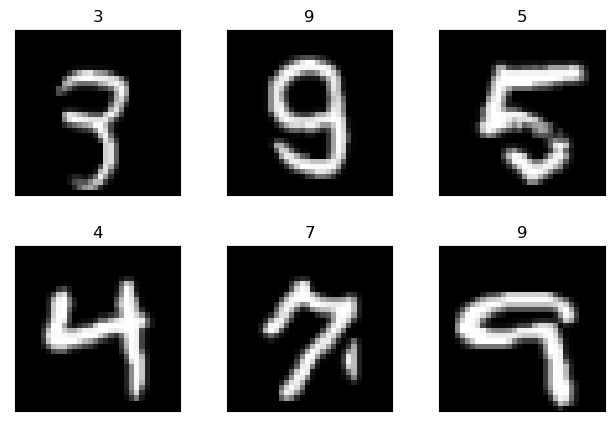

In [103]:
import matplotlib.pyplot as plt
train_set,test_set=get_data_mnist(batch_size,resize=resize)
exa_data,true_num=next(iter(test_set))
print(exa_data.shape)
fig=plt.figure()
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.tight_layout()
    plt.imshow(exa_data[i][0],cmap='gray')
    plt.title(str(true_num[i].item()))
    plt.xticks([])
    plt.yticks([])

In [104]:
import torch
from torch import nn
LeNet=nn.Sequential(
    nn.Conv2d(1,6,kernel_size=5,padding=2),
    nn.ReLU(),
    nn.AvgPool2d(kernel_size=2,stride=2),
    nn.Conv2d(6,16,kernel_size=5),
    nn.ReLU(),
    nn.AvgPool2d(kernel_size=2,stride=2),
    nn.Flatten(),
    nn.Linear(16*36,120),nn.ReLU(),
    nn.Linear(120,84),nn.ReLU(),
    nn.Linear(84,10)
)
test=torch.rand(size=(1,1,32,32),dtype=torch.float32)
for layer in LeNet:
    test = layer(test)
    print(layer.__class__.__name__,'output shape: \t',test.shape)



Conv2d output shape: 	 torch.Size([1, 6, 32, 32])
ReLU output shape: 	 torch.Size([1, 6, 32, 32])
AvgPool2d output shape: 	 torch.Size([1, 6, 16, 16])
Conv2d output shape: 	 torch.Size([1, 16, 12, 12])
ReLU output shape: 	 torch.Size([1, 16, 12, 12])
AvgPool2d output shape: 	 torch.Size([1, 16, 6, 6])
Flatten output shape: 	 torch.Size([1, 576])
Linear output shape: 	 torch.Size([1, 120])
ReLU output shape: 	 torch.Size([1, 120])
Linear output shape: 	 torch.Size([1, 84])
ReLU output shape: 	 torch.Size([1, 84])
Linear output shape: 	 torch.Size([1, 10])


In [105]:
def init_weight(module):
    if(type(module)==nn.Linear or type(module)==nn.Conv2d):
        nn.init.xavier_uniform_(module.weight)

def train(train_set,epoch,lr):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    loss=nn.CrossEntropyLoss()
    train_losses=[]
    train_acc=[]
    net=LeNet
    net.to(device)
    net.apply(init_weight)
    optimizer=torch.optim.SGD(net.parameters(),lr=lr)
    for i in range(epoch):
        metric=Accumulator(3)
        net.train()
        for X,y in train_set:
            X,y=X.to(device),y.to(device)
            optimizer.zero_grad()
            y_hat=net(X)
            l=loss(y_hat,y)
            l.backward()
            optimizer.step()
            metric.add(l.item()*X.shape[0],getAccuracy(y_hat,y)*X.shape[0],X.shape[0])
            train_losses.append(l.item())
            train_acc.append(getAccuracy(y_hat,y))
        t_loss=metric[0]/metric[2]
        t_acc=metric[1]/metric[2]
        print(f'第{i+1}次训练,loss为{t_loss},acc为{t_acc}')
    train_counter=[i+1 for i in range(len(train_losses))]
    g=Graph('num','acc or losses')
    g.addLine(train_counter,train_losses,color='blue')
    g.addLine(train_counter,train_acc,color='red')
    g.addLegend(['loss','acc'])
    g.show()
    return net


第1次训练,loss为0.5865000641862551,acc为0.8158833333333333
第2次训练,loss为0.09904071971178055,acc为0.9701166666666666
第3次训练,loss为0.0686477442642053,acc为0.9788166666666667
第4次训练,loss为0.05474726405143738,acc为0.9834333333333334
第5次训练,loss为0.04377182892958323,acc为0.9861666666666666


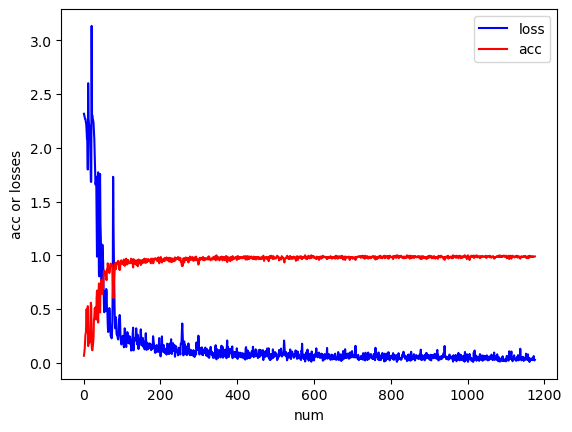

In [106]:
net=train(train_set,5,0.3)